In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx


from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer


In [2]:
sns.set_style("ticks")

In [3]:
# Load data

train = pd.read_csv('./data/train.csv')
greeks = pd.read_csv('./data/greeks.csv')
test = pd.read_csv('./data/test.csv')

In [4]:
# Set index

train = train.set_index('Id')
test = test.set_index('Id')
greeks = greeks.set_index('Id')

# Separate target and features
X = train.drop('Class', axis = 1)
y = train['Class']

In [5]:
# Get features list
violin_features = list(X.columns)
categorial_features = X.columns[X.dtypes != float].values.tolist()

# Remove non-float features
violin_features.remove(*categorial_features)

print(categorial_features)

['EJ']


In [6]:
# Encode categorial object 'EJ' feature 

enc = OneHotEncoder()
enc.fit(X['EJ'].values.reshape(-1, 1))
onehot_cols = ['EJ' + '_' + x for x in enc.categories_[0]]

X[onehot_cols] = enc.transform(X['EJ'].values.reshape(-1, 1)).toarray()
X = X.drop('EJ', axis = 1)

#test[onehot_cols] = enc.transform(test['EJ'].values.reshape(-1, 1)).toarray()
#test = test.drop('EJ', axis = 1)

#violin_features.extend(onehot_cols)

In [7]:
# Check which features are missing and how many missing data points are there

nas = X.isnull().sum()[X.isnull().sum() > 0]
nas

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [8]:
# Since the features which contain missing values are not normally-distributed, we will use iterative imputer. 

imp = KNNImputer(weights = 'distance', n_neighbors=20) # weight by distance but use many neighbors
X2 = pd.DataFrame(imp.fit_transform(X), index = X.index, columns = X.columns)

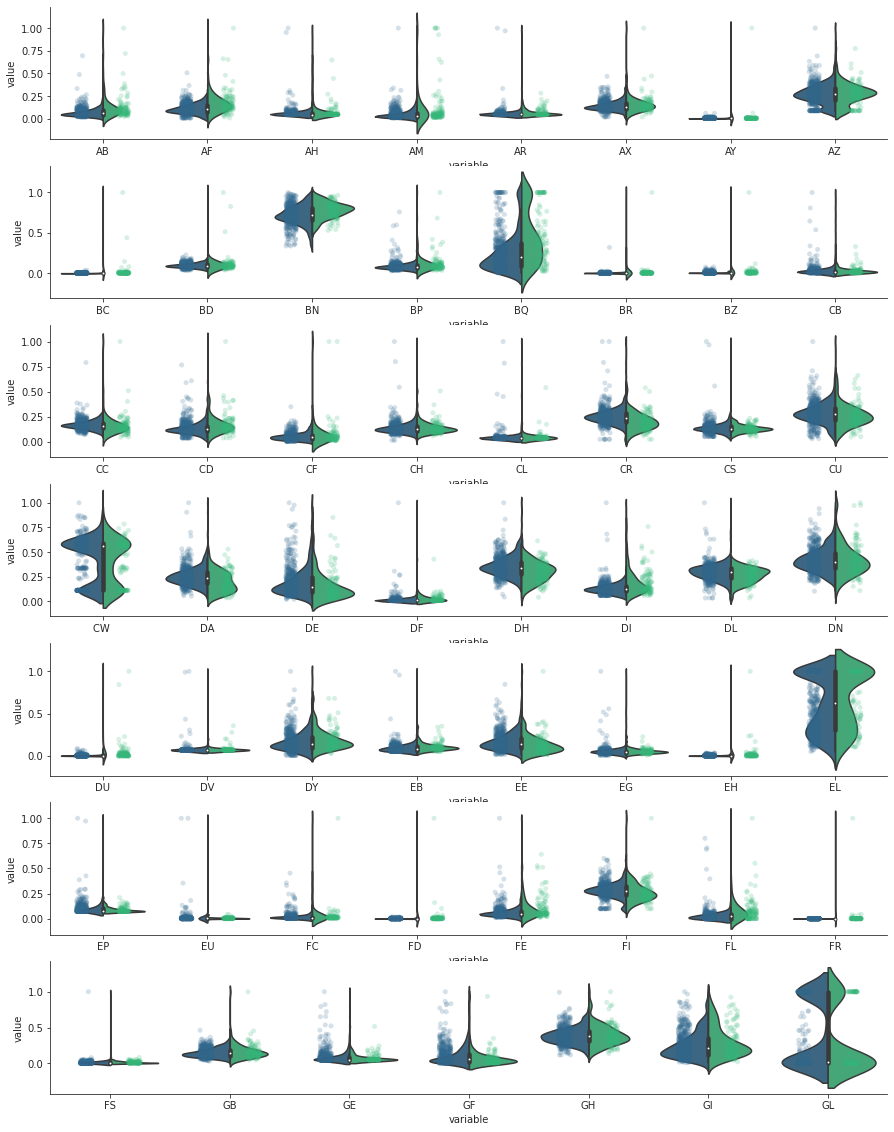

In [9]:
# Plot violin plots of non-categorial features

fig, axs = plt.subplots(nrows = 7, ncols = 1, figsize = (15, 20))

axs = np.ravel(axs)

for row in range(7):
    features = violin_features[row*8:(row+1)*8]
    #df_plot = pd.concat([X2[features], y], axis = 1)
    df_plot = pd.concat([X2[features], y], axis = 1)
    df_plot = df_plot / df_plot.max(axis = 0) # Normalize them for plotting purposes
    df_plot = df_plot.melt(id_vars = ['Class'], value_vars = features)
    sns.violinplot(data = df_plot, x = 'variable', y = 'value', hue = 'Class', split = True,palette = 'viridis', ax = axs[row])
    sns.stripplot(data = df_plot, x = 'variable', y = 'value', hue = 'Class', dodge = True,palette = 'viridis', alpha = 0.2, ax = axs[row])
    axs[row].get_legend().remove()
sns.despine()
#plt.tight_layout()

Semi-insights:
*Highly concentrated AY, BC, BR, BZ, DU, EH, EU, FR  <br>
* Large AM -> Highly likely Green <br>
* Large CR -> Slightly likely blue <br>
* Large DH -> Slightly likely blue <br>
* Large DA -> Slightly likely blue <br>
* Large EE -> Slightly likely blue <br>
* Large FI -> Slightly likely blue <br>
<br>

Before studying the correlations, let us complete the missing values.

In [11]:
# Plot categorial

In [13]:
df_corr = train.corr().abs()
corr_pairs = df_corr.unstack().dropna().sort_values(ascending=False)
selected_corr_pairs = corr_pairs[(corr_pairs < 1) & (corr_pairs > 0.75)]
selected_corr_pairs = selected_corr_pairs.iloc[::2] # drop the identical 
selected_corr_pairs

FD   EH     0.971152
CL   DV     0.948991
BZ   BC     0.907981
EH   DU     0.850957
DV   AR     0.823012
FD   DU     0.805989
CS   EP     0.794158
AR   EP     0.754615
BC   BD     0.753051
dtype: float64

In [14]:
len(selected_corr_pairs)

9

Spaces?

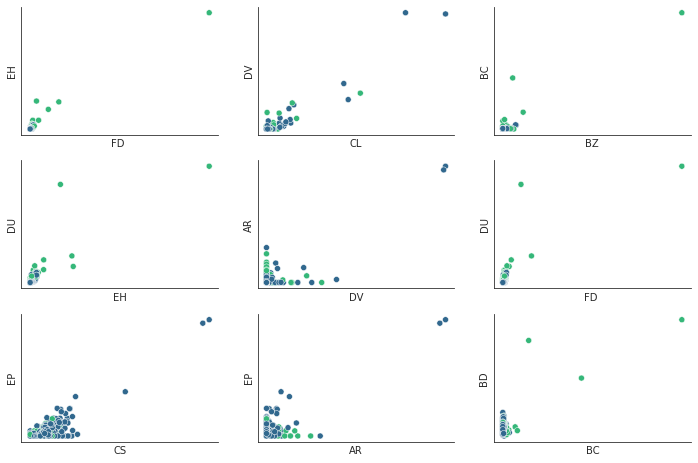

In [15]:
# Plot calibration plots of highly correlated categorial features

fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 8))

axs = np.ravel(axs)

for i, ax in enumerate(axs):
    f1, f2 = selected_corr_pairs.index[i] 
    sns.scatterplot(data = train[[f1, f2, 'Class']], x = f1, y = f2, hue = 'Class', ax = axs[i], palette='viridis')
    #sns.regplot(data = train[[f1, f2, 'Class']], x = f1, y = f2, ax = axs[i])

    axs[i].get_legend().remove()
    axs[i].set_xticks([])
    axs[i].set_yticks([])
sns.despine()


In [16]:
selected_corr_pairs = corr_pairs[(corr_pairs < 1) & (corr_pairs > 0.6)]
selected_corr_pairs = selected_corr_pairs.iloc[::2] # drop the identical 
selected_corr_pairs
G = nx.DiGraph(selected_corr_pairs.index.to_list())

In [17]:
def generate_points_on_circle(nodes, radius=1):
    points = {}
    num_points = len(nodes)
    for i in range(num_points):
        angle = 2 * np.pi * i / num_points
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        points[nodes[i]] = (x, y)
    return points

# Generate 15 points on the circle with radius 1
points_on_circle = generate_points_on_circle(list(list(G.nodes())))


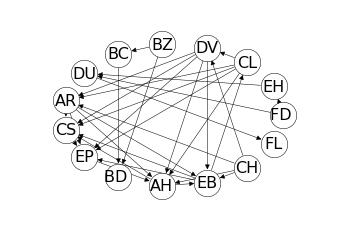

In [20]:
params = {
    "font_size": 16,
    "node_size": 700,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 0.5,
    "width": 0.5,
}
nx.draw_networkx(G, points_on_circle, **params)
ax = plt.gca()
ax.margins(0.2)
plt.axis("off")
plt.show()

In [21]:
# Add clusters